# Lyric-Based ML Exploration on Taylor Swift Eras Tour

## Overview
Recently, Taylor Swift had held her world tour concert in Singapore, the place where I came from. As an avid fan of Taylor Swift I wanted to do some interesting data science/machine learning projects about her. Thats where I went to search for Taylor Swift dataset in Kaggle, and to my surprise, I came across a dataset of her songs during her Eras Tour. Which makes me wonder if I could practice and utilize machine learning techniques to start an interesting analysis and project for myself.

## Objectives
And so I thought it would be interesting to develop a machine learning model that is able to predict or detect which Eras a lyric is from. I plan to employ TF-IDF to breakdown the lyrics into numerical format and then perform different feature engineering techniques in classify the lyrics by Eras. I plan to use multiple machine learning model to compare and evaluate its performance, such as Logistic Regression, Naive Bayes, Support Vector Machines(SVM), Random Forest.

## Dataset description
Dataset soucre : https://www.kaggle.com/datasets/amouschocolovski/taylor-swift-era-tour-dataset/data . The dataset consist of a csv file where it include a csv file. The dataset consist of informations such as Song name, its Era, the lyrics of the song line to line, and the line number of the song. As stated by the author, the song list is sourced from https://genius.com/Taylor-swift-the-eras-tour-setlist-annotated , and the lyrics are organized by using python packages: https://lyricsgenius.readthedocs.io/en/master/ , which is a python client for Genius API.

# Data preparation

Prepares the dataset and imports and understands the dataset's compositions.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px
pio.renderers.default = "notebook"
from wordcloud import WordCloud

pd.set_option("display.max_colwidth", None)

C:\Users\Tom_N\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
## load dataset
df = pd.read_csv("lyrics_data.csv")
print(df.shape)
df.sample(10)

(2431, 4)


SongName             Era  \
1147  We Are Never Ever Getting Back Together         Red Act   
1973                           Wildest Dreams        1989 Act   
2166                                Anti-Hero   Midnights Act   
1011                                Long Live   Speak Now Act   
2223                           Vigilante Shit   Midnights Act   
212                                     Lover       Lover Act   
1631                          illicit affairs    folklore Act   
695                          ...Ready For It?  reputation Act   
1419                         invisible string    folklore Act   
2212                            Midnight Rain   Midnights Act   

                                                 Lyrics  LineNum  
1147                                         Like, ever       16  
1973                             Wildest dreams, ah, ha       32  
2166                                        It's me, hi       41  
1011  How the kingdom lights shined just for me and you       13  
2223             Lately, I've been dressin' for revenge        6  
212                        Can we always be this close?        5  
1631                        A dwindling, mercurial high       18  
695                        We'll move to an island, and       20  
1419                    Getting lunch down by the Lakes       18  
2212                       I guess sometimes we all get       39

### Find out the number of songs(unique) from each Eras
Ploty express is used to create the bar graph to show the numbers of unique songs from each Eras. This information might be useful to determine any biasness from the model's performance, because if an Era has a significantly less songs, showing signs of an imbalanced dataset as they are a minority as compared to other Era.

In [3]:
# Count unique songs in each Era
songs_per_era = df.groupby('Era')['SongName'].nunique().reset_index(name='NumberOfSongs')

# Plotting the number of songs per Era
fig = px.bar(songs_per_era, x='Era', y='NumberOfSongs', title='Number of Songs in Each Era',
             labels={'NumberOfSongs': 'Number of Songs', 'Era': 'Era'}, color='Era')
fig.update_layout(showlegend=False)
fig.show()

From the bar graph, it is evident that Speak Now Act and Fearless Act has 2 and 3 songs in its Era respectively, which is the least amount of songs as compare to other Eras.

A histogram plot is plotted to show every song titles and their total number of lyrics line in each Era. This count amount roughly tells us the average of having more lyrics in the song which also means the length of the songs are generally longer. In addition, this also helps to highlight any imbalances of towards certain eras as they might have lesser songs and lyrics.

In [4]:
px.histogram(df, y="SongName", color="Era", title="Songs and its total number of lyrics line in each Eras")

# Preprocessing data

Removes all special characters from the text and convert text to lowercase. This is standardize the text data by removing unnecessary "noise" as they often do not contribute to the meaning of the text in the context of NLP and therefore will make the process cleaner to focus more on the textual content that carries semantic meaning. It is required to convert the all text to lowercase to ensure the same words are recognised as identical regardless of their casing. In lyrics especially, you can come across with words at the beginning of a lyrics with a uppercase, or you can have lyrics in all uppercase when it is written as an expression. For example: "Love" "LOVE" and "love" will be considered three different tokens, which is not what I want here. Therefore, by normalizing text to lowercase to treat all variations of words as the same token to better assist in my objectives in counting of words occurences accurately as well as understanding the text context better.

In [5]:
import re

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[\W_]+', ' ', text)  # Remove special characters
    return text

df['Lyrics'] = df['Lyrics'].apply(preprocess_text)

Find out the columns names and check for any missing values in the dataset. If there are missing values in the dataset, drop them as they will not be useful.

In [6]:
# Display the column names
print("Column names:", df.columns.tolist())

Column names: ['SongName', 'Era', 'Lyrics', 'LineNum']


In [7]:
print(df.isnull().sum())

#If there are missing values, drop them as they wont be useful
#Example: df.dropna(subset=['Lyrics'], inplace=True)

SongName    0
Era         0
Lyrics      0
LineNum     0
dtype: int64


### Removing stopwords from Lyrics

Then stopwords are moved from the song lyrics as they are unlikely to be useful in the analysis or to the model. "oh" is also removed as they are often in many Taylor Swift songs, thus I feel it might not provide any insightful value.

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

# Load stop words
stop_words = set(stopwords.words('english'))
#After noticing "oh" is very common among most Era
stop_words.update(['oh'])

# Function to remove stop words
def remove_stop_words(lyrics):
    word_tokens = word_tokenize(lyrics)
    filtered_lyrics = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_lyrics)

# Apply the function to your lyrics column
df['Lyrics'] = df['Lyrics'].apply(remove_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tom_N\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tom_N\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Plotting WordCloud visualization

The wordcloud helps to reveal common words in each eras and highlights words that appeared the most based on its frequency of words occcurances. So words that appeared most in the Era would have the biggest font in the WordCloud.

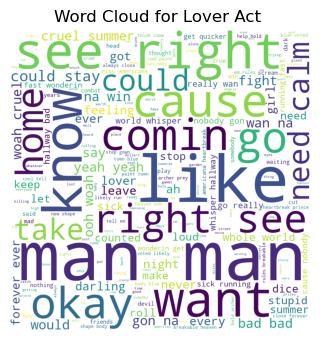

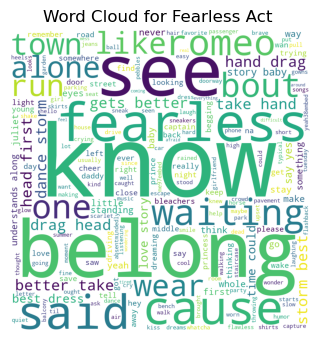

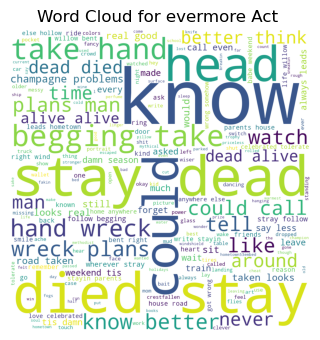

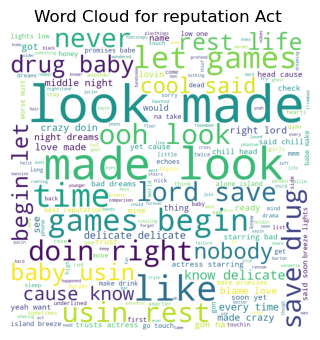

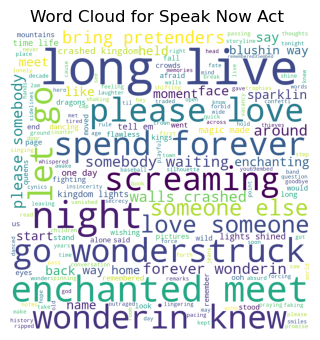

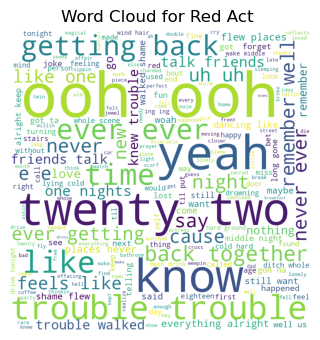

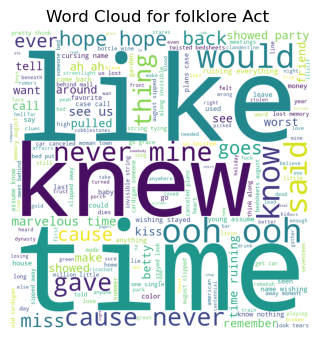

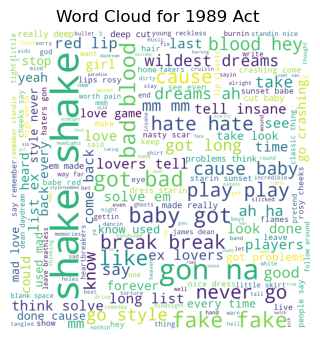

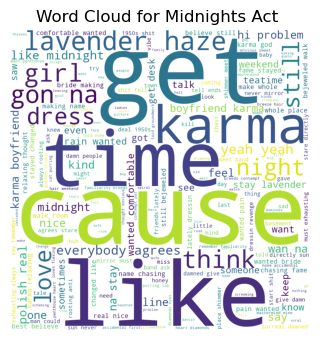

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get unique eras
eras = df['Era'].unique()

for era in eras:
    # Aggregate lyrics for the era
    era_lyrics = ' '.join(df[df['Era'] == era]['Lyrics'])
    
    # Generate word cloud
    wordcloud = WordCloud(width = 1000, height = 1000,
                          background_color ='white',
                          stopwords = stop_words,
                          min_font_size = 4).generate(era_lyrics)
    
    # Plot the word cloud
    plt.figure(figsize=(3, 3), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(f"Word Cloud for {era} ")
    plt.show()


### WordCloud analysis

From the generated wordclouds, it is evident to see that the most common words used in each Eras are:

Lover Act: Words like "man" and "right" stood out from the rest as they held more value. A noticible patterns from Lover Act is there the words font size are more __evenly distributed__ as there are more words with the similar big font size. This shows that there is a diverse range of themes and topics within the lyrics with no single theme being significantly more prevalent than the rest.

Fearless Act: It has a __slightly more skewed distribution__ with a small numbers of words are much more common than the rest. Words like "fear","less" and "belong" appeared biggest,which represents the main theme in the Era. 

Evermost Act: __Even and balanced distributions__ of words and themes in this Era, only words that stood out are "dead" ,"stay","died","know" which also represents the main theme of the Era.

Reputation Act: This also has a __even and balanced distributions__of words which shows that there are multiple themes in this Era which can make predictiing songs from this Era difficult. However one word that stood out is "look" given that it appeared 4 times with different font size in the WordCloud.

Speak Now Act: This Era have words that are more complex and have a deeper sementic meaning. They also have an __even distribution__ of words and themes, however words like "enchanted",long live","spend forever","love someone" are all words with a similar theme.

Red Act: It has a __slightly more skewed distributions__ of words, with words like "twenty two", "getting back","trouble trouble" which highlights the unique words and themes of this Era. Which should also means that lyrics with these words will be easily classified and detected to be from this Eras as they are words that only appeared in the Red Era.

Folklore Act: It has the __most skewed distributions__ of words in this Era. With common words like "time","like","knew","said" are very common used words in Taylor Swift's song across all the different Eras, thus it should be the more difficult to detect songs from this Eras.

1989 Act: It has a __most balanced and even distributions__ of words in this Era. This highlights that songs from this Eras have a diverse range of themes across all the songs. Across common words, they are mostly unique and words with deeper semantic meanings which can be useful for the machine learning model to make better predictions for lyrics from this Era.

Midnights Act: This Era has a __skewed distributions__ of words with common words such as "cause","time","like","get" which are common stopwords which slightly less semantic values. The only exceptions is "karma" being the only unique common word in this Era. 

# Feature engineering

Term Frequency-Inverse Document Frequency(TF-IDF) is used to transform the lyrics into a numerical format so that the machine learning algorithms can understand. It also help to quantify the importance of each words in the context of a song relative to the dataset, which lead to an easier process to capture the unique characteristics of the lyrics in each Era. 

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Fit and transform the 'Lyrics' column
X_tfidf = tfidf_vectorizer.fit_transform(df['Lyrics']).toarray()

# Getting the target variable 'Era'
y = df['Era']
 

### Splitting dataset with train test split

To evaluate the performance of our machine learning model, we split the dataset into training and testing sets. This allows us to train the model on a portion of the data (the training set) and then test its performance on unseen data (the testing set). This step is critical for assessing how well our model generalizes to new, unseen data.

## Logistic Regression base model
Logistic Regression as our initial base machine learning model due to its simplicity and effectiveness in classification tasks. After training the model on the TF-IDF features of the training set, the model learns to associate certain patterns of word importance with specific eras of Taylor Swift's music.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initiate Logistic Regression
model = LogisticRegression(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict the test results
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

      1989 Act       0.63      0.63      0.63        68
  Fearless Act       0.88      0.26      0.40        27
     Lover Act       0.60      0.47      0.53        59
 Midnights Act       0.49      0.61      0.54        61
       Red Act       0.53      0.63      0.58        70
 Speak Now Act       0.78      0.28      0.41        25
  evermore Act       0.77      0.48      0.59        63
  folklore Act       0.35      0.61      0.44        62
reputation Act       0.73      0.69      0.71        52

      accuracy                           0.55       487
     macro avg       0.64      0.52      0.54       487
  weighted avg       0.61      0.55      0.56       487



From the classification report, the Logistric Regression model has an accuracy score of 0.55 which is 55%, which means the model correctly predicts the Era 55% of the time across all Eras in the test set. It also has a macro average F1-score of 0.54.

### Choice of metrics for evaluation
__Accuracy__: Simple and straightforward to capture the basic model predictive performance

__Macro Average F1-score__: This is the unweighted mean of the F1-scores for each class, which means they treat all classes equally regardless of the number of true instances for each label. This is useful when the dataset have class imbalances. It also considers both precision and recall which provides a balanced view of the model's predictive performances across all classses. This is because both Presicion and Recall are equally important in this classification task.

### Confusion matrix visualisation

A confusion matrix is able to break down the predictions into four categories of : true positives, true negatives, false positives and false negatives. This allows us to see how often the model is right and where it is right or wrong with its predictions.

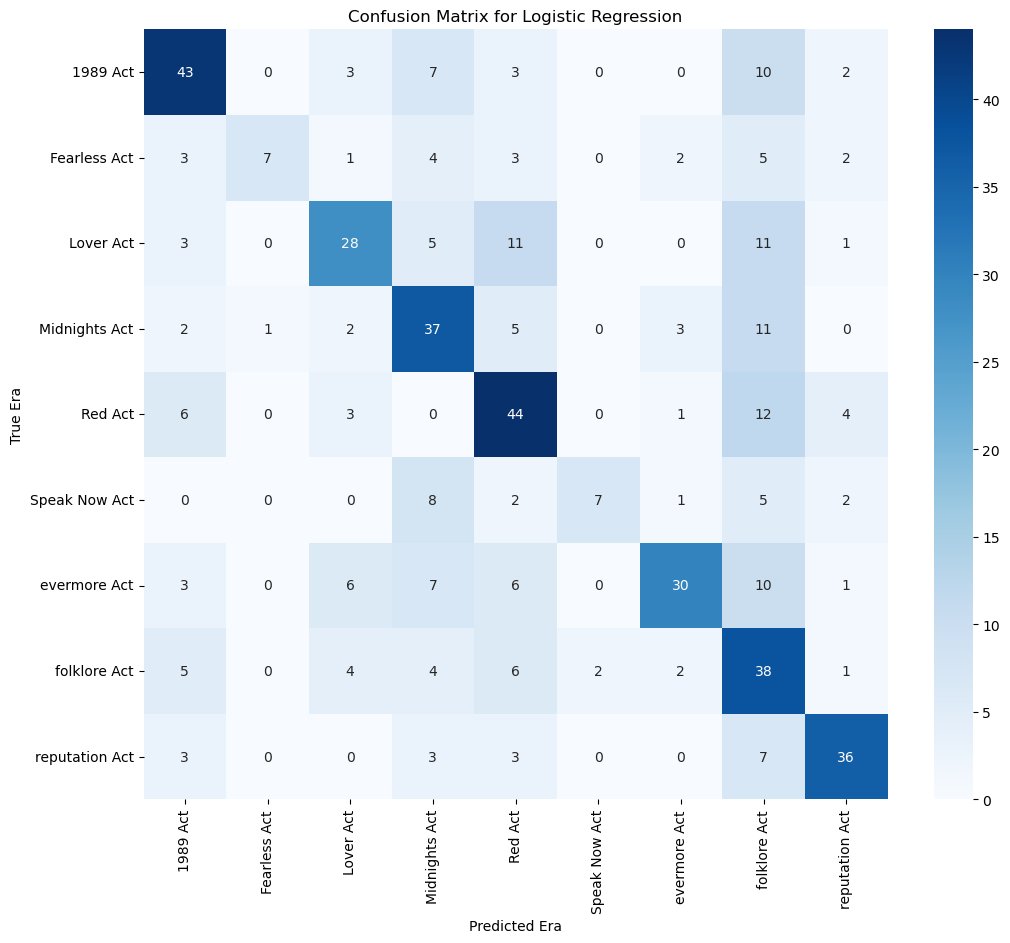

In [12]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm_lr = confusion_matrix(y_test, y_pred)

# Sort the "Era" in order for display
labels = sorted(df['Era'].unique())

# Plotting the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Era')
plt.ylabel('True Era')
plt.show()

#### Confusion matrix evaluation 
It has 270 total true positives, 217 total false negatives and 217 false positive. True negatives does not usually provide meaningful insight when it comes to a multi-class setting thus it will be left out in the evaluation. The model performed badly when it comes to detecting songs from folklore Eras.


A predict Era function is created to test a example usage of the model. To show what Era did the model predicts for the selected input.

In [13]:
def predict_era(keywords):
    # Transform the keywords to match the trained TF-IDF vectorization
    keywords_tfidf = tfidf_vectorizer.transform([keywords]).toarray()
    
    # Predict the era
    era_prediction = model.predict(keywords_tfidf)
    
    return era_prediction[0]

# Example usage
predicted_era = predict_era("shake it off")
print(f"The predicted era for the given keywords is: {predicted_era}")


The predicted era for the given keywords is: 1989 Act


## Naive Bayes base model

Exploring additional machine learning models with different algorithm is necessary to broaden the analytical approace. Naive Bayes is chosen this time as test and explore its strengths in handling text classification task, which it uses Bayes's theorem and assumes independence between predictors. This model performances will then be evaluated and compared with all the models from this project.

In [14]:
from sklearn.naive_bayes import MultinomialNB

# Initialize the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the classifier
nb_classifier.fit(X_train, y_train)

# Predict the test set results
y_pred_nb = nb_classifier.predict(X_test)
print(classification_report(y_test, y_pred_nb))

                precision    recall  f1-score   support

      1989 Act       0.53      0.68      0.59        68
  Fearless Act       0.86      0.22      0.35        27
     Lover Act       0.65      0.47      0.55        59
 Midnights Act       0.38      0.67      0.49        61
       Red Act       0.51      0.63      0.56        70
 Speak Now Act       1.00      0.16      0.28        25
  evermore Act       0.88      0.44      0.59        63
  folklore Act       0.43      0.47      0.45        62
reputation Act       0.62      0.63      0.63        52

      accuracy                           0.53       487
     macro avg       0.65      0.49      0.50       487
  weighted avg       0.61      0.53      0.53       487



From the classification report, the Naive Bayes base model has an accuracy score of 0.56 which is 56%, which means the model correctly predicts the Era 55% of the time across all Eras in the test set. It also has a macro average F1-score of 0.54. It has a very marginally better accuracy than the Logicstic Regression base model's performance.

## Utilizing n-grams in TF-IDF
n-grams are added into the TF-IDF vectorization to hope that it can capture more context around each words, especially since song lyrics in each lines are linked to one another, so that it can help to better predict by pinpointing the exactly phrases from the specific Era. n-gram  works by combining the adjacent words as features into the dataset depending on the range. I have used a minimum n-gram range of 1 and a maximum range of 3.

In [15]:
# Initialize the TF-IDF Vectorizer to include unigrams and bigrams
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 3))

# Fit and transform the 'Lyrics' column
X_tfidf_ngrams = tfidf_vectorizer.fit_transform(df['Lyrics']).toarray()

### Feature engineering : adding n-gram feature into the Logistic Regression base model

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_ngrams, y, test_size=0.2, random_state=42)

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

      1989 Act       0.70      0.63      0.67        68
  Fearless Act       0.70      0.26      0.38        27
     Lover Act       0.57      0.56      0.56        59
 Midnights Act       0.37      0.72      0.49        61
       Red Act       0.59      0.63      0.61        70
 Speak Now Act       0.80      0.32      0.46        25
  evermore Act       0.86      0.49      0.63        63
  folklore Act       0.46      0.53      0.49        62
reputation Act       0.78      0.67      0.72        52

      accuracy                           0.57       487
     macro avg       0.65      0.54      0.56       487
  weighted avg       0.63      0.57      0.57       487



From the classification report, the Logistic Regression model with n-gram feature has an accuracy score of 0.57 which is 57% and slightly better than 0.55 of the Logistic Regression base model. This also means the model correctly predicts the Era 57% of the time across all Eras in the test set. It also has a better macro average F1-score of 0.56 as compared to the base Logistic Regression model of 0.54.

## Support Vector Machines base model

As I further the exploration of different machine learning model, Support Vector Machines(SVM) is used this time. SVM is known for handling non-linear data relationships as well as the ability to find the optimal hyperplane that seperates different classes with maximum margin. The parameters for the base model is to use linear kernel first, with C value of 10. This C value basically tells the SVM how much I want to avoid misclassifying each training example. With the large value of C will means the model optimization will choose a smaller-margin hyperplane.

In [17]:
from sklearn.svm import SVC

# Initialize and train the SVM model
svm_model = SVC(kernel='linear', C=10)  # Start with linear kernel
svm_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_svm = svm_model.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Classification Report:
                precision    recall  f1-score   support

      1989 Act       0.70      0.72      0.71        68
  Fearless Act       0.50      0.33      0.40        27
     Lover Act       0.59      0.56      0.57        59
 Midnights Act       0.58      0.61      0.59        61
       Red Act       0.67      0.53      0.59        70
 Speak Now Act       0.53      0.36      0.43        25
  evermore Act       0.82      0.57      0.67        63
  folklore Act       0.34      0.65      0.44        62
reputation Act       0.76      0.65      0.70        52

      accuracy                           0.58       487
     macro avg       0.61      0.55      0.57       487
  weighted avg       0.62      0.58      0.59       487



The SVM base model using linear kernal and C value of 10, resulted in an accuracy of 0.58, which is slightly better than all the previous models' performance so far, and it has an  macro average f1-score of 0.57, which is also better than the previous model's performance.

### SVM model with best hyperparameter using GridSearchCV

Then I integrated GridSearchCV from sklearn to systemically explore a selected range of hyperparameters in order to find the most optimal configuration that maximizes the model's overall performance. 

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid to search over
param_grid_svm = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf'
}

# Initialize the SVM classifier
svm = SVC()

# Set up GridSearchCV
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=4, scoring='accuracy', verbose=1)

# Fit GridSearchCV
grid_search_svm.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters for SVM:", grid_search_svm.best_params_)
print("Best score for SVM:", grid_search_svm.best_score_)

# Evaluate on the test set
y_pred_svm = grid_search_svm.predict(X_test)
print("SVM Classification Report (with best parameters):")
print(classification_report(y_test, y_pred_svm))

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best score for SVM: 0.5715020576131689
SVM Classification Report (with best parameters):
                precision    recall  f1-score   support

      1989 Act       0.77      0.72      0.74        68
  Fearless Act       0.53      0.37      0.43        27
     Lover Act       0.60      0.58      0.59        59
 Midnights Act       0.59      0.64      0.61        61
       Red Act       0.62      0.54      0.58        70
 Speak Now Act       0.57      0.32      0.41        25
  evermore Act       0.80      0.57      0.67        63
  folklore Act       0.32      0.61      0.42        62
reputation Act       0.77      0.65      0.71        52

      accuracy                           0.59       487
     macro avg       0.62      0.56      0.57       487
  weighted avg       0.63      0.59      0.60       487



From GridSearchCV with 4 folds, the best hyperparameters for SVM model to yield the highest accuracy is rbf kernel with scaled gamma, together with C value of 10. From the classification report, the SVM model has an accuracy score of 0.59 which is 59%, which means the model correctly predicts the Era 59% of the time across all Eras in the test set, which is also slightly better than the SVM base model. It also has a macro average F1-score of 0.57 which is the same as the SVM base model.

### Confusion matrix visualisation for SVM with the best parameters

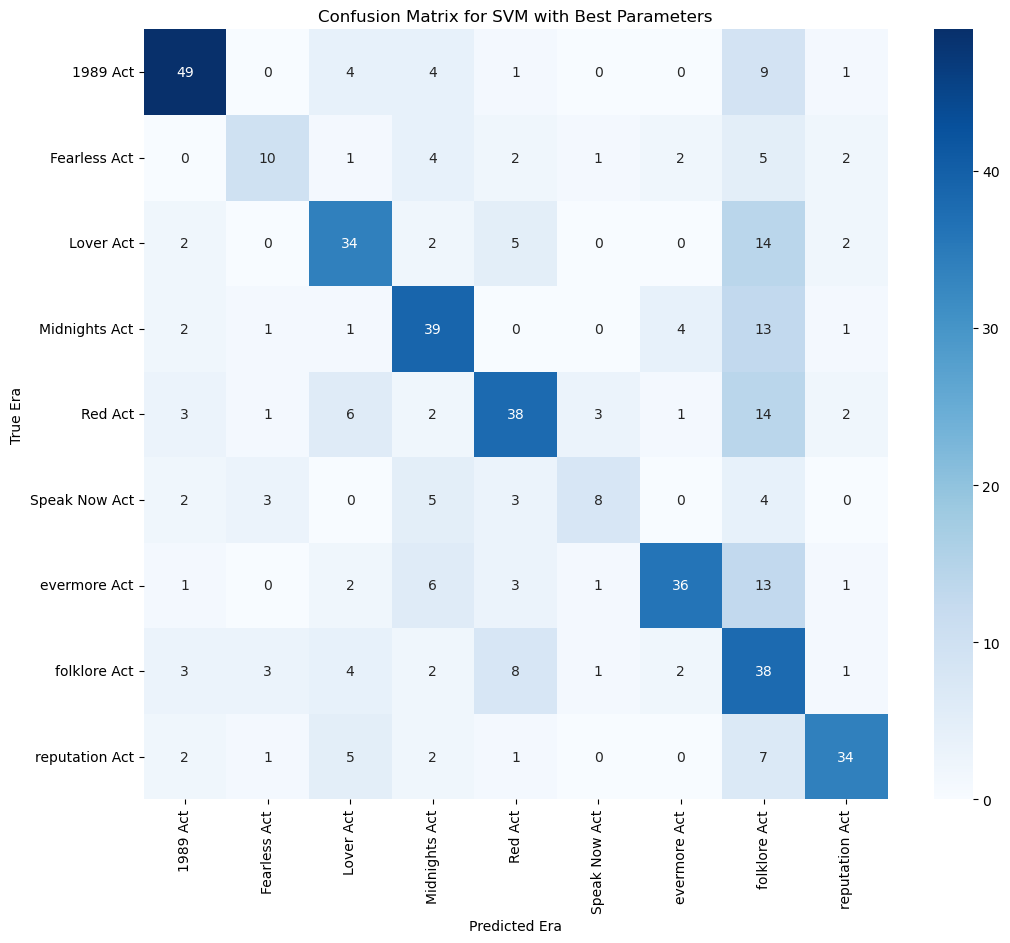

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Assuming you have the labels sorted or in a specific order you want to display
labels = sorted(df['Era'].unique())

# Plotting the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for SVM with Best Parameters')
plt.xlabel('Predicted Era')
plt.ylabel('True Era')
plt.show()


#### Confusion matrix evaluation 
It has 286 total true positives, 201 total false negatives and 201 false positive. There is an overall improvement in the SVM model as compared to the logistis regression base model of 270 total true positive, 217 false negatives and 217 false positive as the SVM model are able to better predict and detect which Era a lyrics is from. 

However, the SVM model performed slightly worst when it comes to detecting songs from folklore Eras, as they have 79 false positive results as compared to 71 false positive from the logistic regression base model. This means the SVM model incorrectly predicted songs to be in Folklore Eras when they are not. This can be due to the common words in the Folklore Eras having many similarities inlined with the other Eras or the model was overfitted to the training data.

# Random Forest base model

Last but not least, Random Forest algorithm is explored to compare its results with all model's performance. Random Forest generally works by creating a multitude of decision trees at training time and then it makes predictions by aggregating the outcomes of all these trees. It aims to reduced the likelihood of overfitting and also improves the accuracy by its ability to capture a broader range of patterns and relationship within the data.

In [32]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42) 
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
                precision    recall  f1-score   support

      1989 Act       0.72      0.72      0.72        68
  Fearless Act       0.56      0.37      0.44        27
     Lover Act       0.58      0.54      0.56        59
 Midnights Act       0.65      0.61      0.63        61
       Red Act       0.57      0.53      0.55        70
 Speak Now Act       0.75      0.48      0.59        25
  evermore Act       0.78      0.57      0.66        63
  folklore Act       0.34      0.61      0.44        62
reputation Act       0.72      0.69      0.71        52

      accuracy                           0.59       487
     macro avg       0.63      0.57      0.59       487
  weighted avg       0.62      0.59      0.60       487



From the classification report, the Random Forest base model has an accuracy score of 0.59 which is 59% and has the same accuracy as the SVM model with best parameters. This means the model correctly predicts the Era 59% of the time across all Eras in the test set. The Random Forst base model also has the best macro average F1-score of 0.59 as compared to the rest of the models.

### Random Forest model with best hyperparameter using GridSearchCV

Then I integrated GridSearchCV from sklearn to systemically explore a selected range of hyperparameters in order to find the most optimal configuration that maximizes the model's overall performance. 

In [35]:
# Define the parameter grid to search over
param_grid_rf = {
    'n_estimators': [50, 60, 100],  # Number of trees in the forest
    'max_depth': [None, 5, 10],  # Maximum depth of the tree
    'min_samples_split': [ None, 3, 5, 7, 10]  # Minimum number of samples required to split an internal node
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier()

# Set up GridSearchCV
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=4, scoring='accuracy', verbose=1)

# Fit GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best score for Random Forest:", grid_search_rf.best_score_)

# Evaluate on the test set
y_pred_rf = grid_search_rf.predict(X_test)
print("Random Forest Classification Report (with best parameters):")
print(classification_report(y_test, y_pred_rf))


Fitting 4 folds for each of 36 candidates, totalling 144 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 3, 'n_estimators': 60}
Best score for Random Forest: 0.5740740740740742
Random Forest Classification Report (with best parameters):
                precision    recall  f1-score   support

      1989 Act       0.73      0.69      0.71        68
  Fearless Act       0.59      0.37      0.45        27
     Lover Act       0.59      0.54      0.57        59
 Midnights Act       0.64      0.61      0.62        61
       Red Act       0.59      0.57      0.58        70
 Speak Now Act       0.71      0.48      0.57        25
  evermore Act       0.77      0.54      0.64        63
  folklore Act       0.33      0.60      0.42        62
reputation Act       0.71      0.71      0.71        52

      accuracy                           0.59       487
     macro avg       0.63      0.57      0.59       487
  weighted avg       0.63      0.59      0.60       487


From GridSearchCV with 4 folds, the best hyperparameters for Random Forest model to yield the highest accuracy is with zero max depth, minimum sample split value of 3, and its n estimators value of 60. From the classification report, the Random Forest model with the best parameters has an accuracy score of 0.59, which is 59%, which means the model correctly predicts the Era 59% of the time across all Eras in the test set, which is same as the Random Forest base model. It also has a similar macro average F1-score of 0.59 as compared to the Random Forest base model.

### Confusion matrix visualisation for Random Forest model with the best parameters

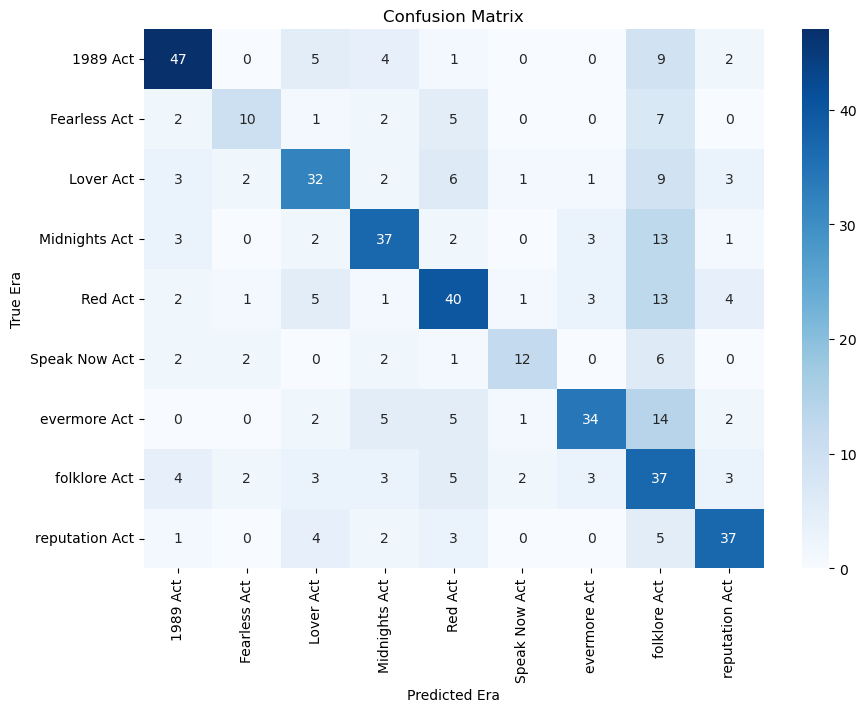

In [37]:
# Assuming y_test and y_pred_rf hold your test labels and Random Forest model predictions, respectively
cm = confusion_matrix(y_test, y_pred_rf)

# Labeling the confusion matrix
labels = df['Era'].unique()
labels.sort()  # Sorting the labels for consistency

# Plotting with seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Era')
plt.ylabel('True Era')
plt.show()


#### Confusion matrix evaluation 
It has 286 total true positives, 201 total false negatives and 201 false positive. Which is the same results as compared to the SVM model with best peramaters,

This time, it has 76 false positives as compared to 79 false positives from the SVM model with best parameters. This means that the Random Forest with best parameters is slighlty better at predicting and detecting lyrics to be in Folklore Era.

# Conclusion

Throughout the project, I aimed to classify her songs into the respective Eras based on lyrical content. Essential data preprocessing was done, including stopword removal and insighful visualization of word clouds, which laid a good foundation for deeper analysis. Feature engineering such as TF-IDF vectorization, using various algorithm for the machine learning model, such as Logistic Regression, Naive Bayes, Support Vector Machines and Random Forest were all implemented. 

From all the results gathered from the analysis, I can conclude a few things: 

1) The implementation of introducing n-grams into TF-IDF vectorization made a pivotal improvements for the Logistic Regression model's accuracy to 0.57 and its average macro f1-score to 0.56. 

2) The further exploration of using SVM model and Random Forest model results in the best predictive performances, with both the model with its hyperparamaters optimized with GridSearchCV. Both models managed to perform with an accuracy of 0.59. The only differences was that the SVM model's f1-score was slightly lower at 0.57 as compared to 0.59 of the Random Forest model.(after both models's hyperparamters were optimized by GridSearchCV). Therefore, amongst the model, Random Forest model resulted in the best performanced in terms of both accuracy score and f1-score.

3) From the confusin matrix, it is evident that the model was generally able to predict lyrics from every Eras except for the Folklore Act, where there are exceptionally a high number of false positives when it comes to correctly detecting and predicting songs from the Folklore Era. This can be due to its common word being common across many different Eras and those words have least sementic meanings, which can be seen from the word cloud analysis. Which is why the models performances were significantly poor for predicting songs that are from the Folklore Era.

These findings highlighted the importance of feature engineering and model selection in text classification task, such as when it comes to predicting and detecting which Era of the Taylor Swift's album a lyrics belong to.

## Contributions to related domain:

By dissecting Taylor Swift's lyrical content from her songs, this project contributes to the broader domain of musicology and computation linguistics, offering a methodological framework and steps for analyzing lyrical content across an artist's group of albums. This also demostrates the potential of machine learning in uncovering linguistic patterns and trends through musical evolutions as each albums have its own theme.

## Transferability to other domains:

The methodologies and analysis from this project are highly transferable to other domains that requires text classification or analysis. In fact, the usage of combinging preprocessing techniques with advanced machine learning models can be applied to domains such as sentiment analysis, topic modelling in news articles, or catergorizing academics papers.  This shows the versaility and broad applicability of the techniques employed in this project.